# DATA 604 Final Project

Magnus Skonberg | July 14th 2021 | [presentation](https://screenrec.com/share/BEbm1p8csa) 

The real world is full of systems from which we can extend discrete event simulations: toll booths, movie theaters, cafes … anywhere where there’s a queueing component really. When these systems are suboptimal, their inefficiencies lead to unhappy drivers, attendants, patrons, etc. and so our goal is to optimize the simulation as if it were a real world problem.

With this in mind, I elected to **simulate a boutique café**.

![boutique cafe](boutique_cafe.jpg)

Imagine being hired on to consult with a café owner regarding the optimization of one component of their business: the number of tables.

They own a relatively small space (room enough for 5-10 tables), maintain a light staff of 3 that could expand to 5 (if the table number is greater than or equal to 5), and serve up artisanal light fare (good coffee, avocado toast, goat cheese salad and the likes). 

The owner has data regarding average daily table demand (based on an ordinary weekday) and has indicated that customers typically arrive in parties of 4, stay for 30 minutes, and spend 15 dollars per head (or $60 per table). From this data and these specifications, we can model our simulation.

The owner’s problem is that they aren’t sure what number of tables would maximize income and minimize wait time. With 10 tables, wait time might be null but the overhead could take away from revenue. Whereas with 5 tables, the overhead might be reduced but the revenue stream may then be limited and average wait times may spike.

The goal of this simulation is to **determine the number of tables that maximizes income while minimizing wait time**.

## The Simulation

Provided customer demand, our boutique café owner has three major areas of interest:

1. **Table number**: provided a range of 5-10, how many tables should the café have?
2. **Income**: what is the resulting daily income?
3. **Wait time**: what is the corresponding average wait time per party?

The first variable, table number, directly controls the second and third variables and so we will explore the impact of varying our control variable in greater depth below.

We will import the necessary libraries, model customer demand, define useful functions (and equations), run our simulation for each table arrangement, plot the resulting income and average wait time, and then discuss our results, model validity, conclusions and next steps.

## Flow Chart

What follows is a simplified model of a boutique cafe where we're focused on the impact of more vs. less tables:

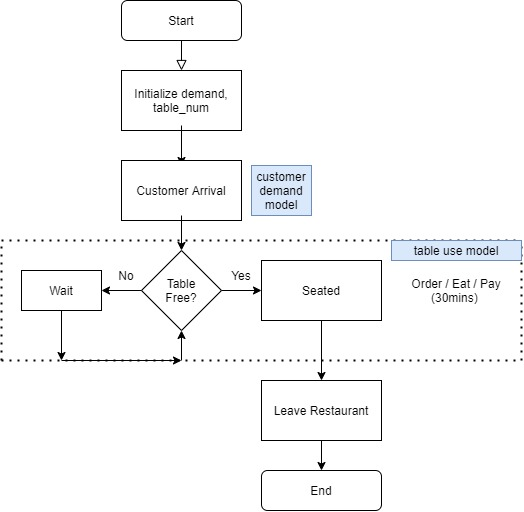

We initialize variables of interest, model customer demand (the rate at which our customers arrive), model table use (based on `customer_demand` and `table_number`) and then proceed to measuring the effect of having a varied number of tables on `income` and `avg_wait_time`.

For the above flow chart we assumed a simple flow through the cafe:

* party arrives at cafe
* party checks in with usher
* if a table is available, the party is shown to their seats
* otherwise, the party waits until a table opens up before being shown to their seats
* all parties are seated, enjoy their meal, pay and then leave.

It's assumed that customer arrival, waiting, and seating can be modeled "like clockwork" via simplified, 30min increments. We use 16 time steps (each representing a 30min increment) to model business opearting hours. *I've done my best to state and justify assumptions made along the way.*


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import necessary libraries and functions
from modsim import *
from random import seed, randint
import statistics
import numpy as np
from matplotlib import pyplot as plt

## Customer Demand

For modeling customer demand we assume:

* an 8 hr "open" timeframe during which the restaurant serves at full capacity
* the ability to model demand with 30 minute increments (of which there are 16), and
* that demand will be random between 0 and 10 tables worth of patrons during this window

The result, which we've made replicable (via seed()), is shown below:

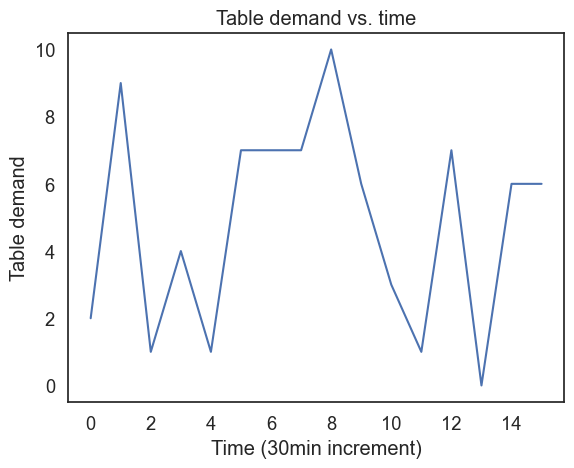

In [2]:
#initialize time increment and table demand
time_slot = np.arange(16)
table_demand = []

# seed random number generator
seed(1)

# generate some integers
for i in range(16):
    table_demand.append(randint(0,10))

#plot results
plt.title("Table demand vs. time") 
plt.xlabel("Time (30min increment)") 
plt.ylabel("Table demand") 
plt.plot(time_slot,table_demand) 
plt.show()

From above we see that our table demand spikes early, recedes, maintains a relatively high demand toward the middle of the day, and then is followed up by 2 later spikes prior to closing.

Considering that our table demand was randomly generated using integers from 0 to 10 (the max. table number), it appears to give a reasonable representation of what a cafe's table demand might actually look like. There are peaks and valleys with opening hours receiving a number of customers, mid-day being the busiest, and a "closing time" push.

From this point, we proceed to defining useful functions.

## Defining Functions

In each of the defined function's, the comments outline input variables and anticipated output. As such, what's provided prior to the code is a high level overview and discussion of equations / assumptions.

* `table_use`: takes the number of tables and the demand for tables (during operating hours) and returns `waiting` - the amount of parties waiting and `table_use` the number of tables used at each point in time during operating hours. *If the demand plus number of parties waiting at any point in time exceeds the number of available tables, the excess parties are added to the waiting list and all tables are assumed to be used, whereas when the demand and number of parties waiting is less than the number of available tables, the number of tables in use is equivalent to the demand and number of parties waiting and the number of parties waiting is assumed to be 0.*
* `cafe_income`: takes the number of tables and the table use list to determine revenue, expenses and income. 

*Note: initially I'd created a `table_demand()` function to model table demand but then I realized this was unnecessary provided the specification states that the owner provided average daily table demand and thus we don't want these figures to vary (ie. using randint()), we want to measure the performance of the cafe at each table number provided this demand.*

The assumptions made in calculating the cafe's daily income include:

* parties are of 4 individuals,
* average spend is 15 dollars per patron --> $60 per table,
* parties spend 30 minutes at the table from start-to-finish,
* staff are paid 20 dollars per hour,
* <= 5 tables carries a 3 person staff (1 host, 1 waiter, 1 chef), whereas greater than 5 tables, carries a 5 person staff (1 additional waiter and chef),
* the cafe operates with fixed daily costs (rent, utilities, etc.) of 500 dollars per day,
* the hourly_table_cost (food, etc.) is 10 dollars per hour,
* work days are 8 hours long,
* `expenses = daily_operations + daily_table_cost + staff_pay`, and
* `income = total_revenue - expenses`.


In [3]:
def table_use(table_num, daily_demand):
    '''
    table_num: number of tables the cafe has
    daily_demand: list of table demand (0-10) at each point in time the cafe is open (16 x 30min time slots)
    
    populate and return table_use, waiting lists based on table availability, prior waiting parties, and current demand
    
    '''
    table_use = []
    waiting = []
    waiting.append(0) #inl_waiting = 0
    
    for i in range(16):

        if (daily_demand[i] + waiting[i-1]) < table_num:
            table_use.append(daily_demand[i] + waiting[i-1])
            waiting.append(0)
        else:
            table_use.append(table_num)
            waiting.append((daily_demand[i] + waiting[i-1]) - table_num)
            
    return table_use, waiting


def cafe_income(table_num, table_use):
    '''
    table_num: number of tables the cafe has
    table_use: list of tables used at each point in time the cafe is open (16 x 30min time slots)
    
    using these input variables and the variables defined below, we calculate revenue and expenses to arrive at and return the corresponding income
        
    '''
    
    #Calculate revenue
    revenue_per_table = 60 #assuming party of 4, $15 each
    revenue = [table_use[i] * revenue_per_table for i in range(16)]
    
    total_revenue = sum(revenue)
    
    #Calculate staff_pay
    staff_hrly = 20 
    
    if table_num <= 5:
        num_staff = 3 #usher, waiter, chef. 
    else:
        num_staff = 5 #one more chef, waiter
        
    staff_pay = num_staff * staff_hrly * 8 #assuming 8hr days
    
    #Calculate fixed costs
    daily_operations = 500 #rent, utilities, etc.
    
    hrly_table_cost = 10 #food, etc.
    daily_table_cost = table_num * hrly_table_cost * 8 
    
    expenses = daily_operations + daily_table_cost + staff_pay
    
    income = total_revenue - expenses
    
    return income


## Running the Simulation

With libraries imported, customer demand modeled, and useful functions defined (including `table_use`), we proceed to running our simulation and observing the impact of table number on daily income and average wait time:

In [4]:
#initialize blank lists to measure the impact of table number on income and avg_wait_time
income = [] 
avg_wait_time = []

demand = table_demand #generate customer demand

num_tables = [i+5 for i in range(6)] #run simulation for 5-10 tables

for i in num_tables:
    table, waiting = table_use(i, demand)
    
    waiting.pop() #remove last entry, there's no waiting once the cafe's closed
    
    income.append(cafe_income(i, table))
    avg_wait_time.append(sum(waiting) * 30 / sum(table))
    

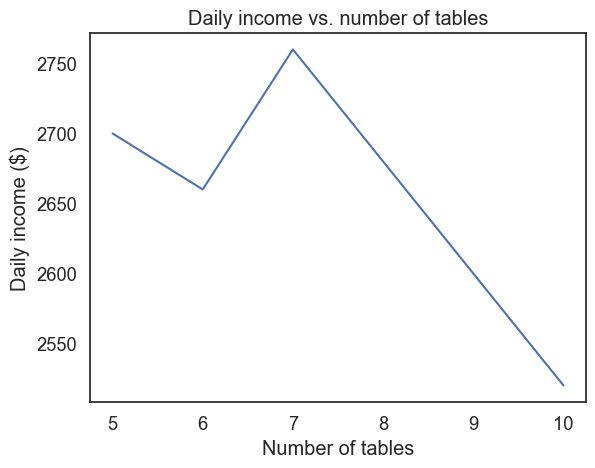

In [5]:
# Income vs. num_tables
plt.title("Daily income vs. number of tables") 
plt.xlabel("Number of tables") 
plt.ylabel("Daily income ($)") 
plt.plot(num_tables,income) 
plt.show()


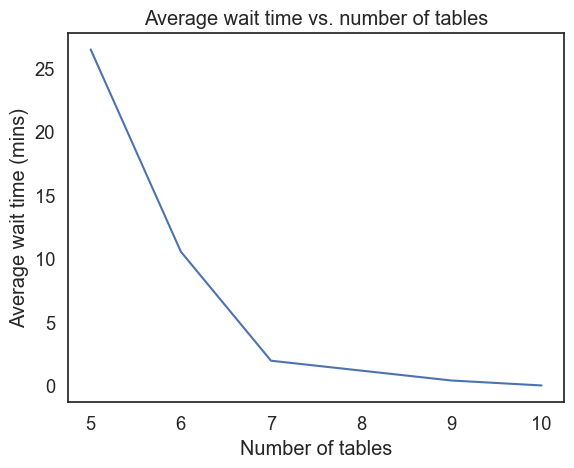

In [6]:
# Avg_wait_time vs. number of tables
plt.title("Average wait time vs. number of tables") 
plt.xlabel("Number of tables") 
plt.ylabel("Average wait time (mins)") 
plt.plot(num_tables,avg_wait_time) 
plt.show()
    

## Analysis

At 7 tables, `Income` reaches a peak greater than $2750 per day and the `avg_wait_time` is less than 5 minutes per table.

While we may have assumed that 10 tables would maximize `Income`, it's worth noting that as the cafe were to expand so too would its `staff_pay` and `daily_table_cost`. It appears that at 7 tables, these additional expenses reach their "sweet spot" in terms of meeting demand. Beyond this point the additional tables are excessive and end up costing business operations.

Based on this simulation, **we'd recommend 7 tables for our boutique cafe**.

## Model Validity

Being that there was no exact data for this specific problem, I took pricing, duration of stay, party size, café size and the problem definition based on a combination of life experience (café’s in Europe), similar models (cited below), and the assumptions stated above. *The 30 minute increment assumption may appear “faulty” on the surface but when we account for the fact that the majority of seated café customers stay for over an hour and the majority of customers (in general) take their goods to go, building in a quicker turnover time (ie. 30 minutes) accounts for the average boutique cafe patron.*

To validate the model, I kept the flow chart as clear and concise as possible, regularly re-verified progress vs. the flow chart (while listing assumptions) and built out the code base chunk-by-chunk. 

The code and inherent logic were verified each step of the way and resulting plots were verified against earlier specifications and assumptions for consistency.


## Conclusion and next steps

"Perfection is achieved, not when there is nothing more to add, but when there is nothing left to take away." 
-Antoine de Saint-Exupery

### Conclusion

While the above simulation is by no means all-encompassing, it does provide a strong starting point and make a strong case for the use of 7 tables in our boutique café owner’s café. Provided the specifications, many of which simplified the implementation of the simulation itself, 7 tables was the clear solution.

With this said, I feel that this simulation could have been “leveled up” and I describe how below.

### Next Steps

The next steps for this project might be to run the simulation using random data so that it doesn’t fit a specific café's average table demand,* rather* it would fit an array of businesses of a similar size, with a similar turnover rate, and such. 

What can be done from running 1000 such simulations would be that through the Law of Large Numbers we’d arrive at a more accurate simulation and one more fitting to a broader array of business types. This would be rather simple in implementation: create a `table_demand` function and then wrap the call to all functions in a `run_simulation` function where we could pass an n parameter for how many times the simulation would run and store the array results in lists or lists of lists (ie. income, avg_wait_time). 

From this list, we would then re-plot and verify whether or not 7 tables is the optimal number for a broader range of customer demand.


## References

In preparing this notebook, I made reference to the following sources:

* https://allendowney.github.io/ModSimPy/ (text)
* https://realpython.com/simpy-simulating-with-python/ (article)
* https://www.youtube.com/watch?v=NypbxgytScM (video)
* https://media.guestofaguest.com/t_article_content/gofg-media/2017/03/1/48630/2h8a3976-2.jpg (image source)